# Product Quantization

In [1]:
import time
import numpy as np
import pandas as pd
from scipy.cluster.vq import vq
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from matplotlib.lines import Line2D

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [3]:
def ivecs_read(fname):
    a = np.fromfile(fname, dtype='int32')
    d = a[0]
    return a.reshape(-1, d + 1)[:, 1:].copy()

def fvecs_read(fname):
    return ivecs_read(fname).view('float32')

def load_sift(name="siftsmall"):
    xt = fvecs_read(f"{name}/{name}_learn.fvecs") # /content/
    xb = fvecs_read(f"{name}/{name}_base.fvecs")
    xq = fvecs_read(f"{name}/{name}_query.fvecs")
    gt = ivecs_read(f"{name}/{name}_groundtruth.ivecs")

    return xb, xq, xt, gt

In [4]:
xb, xq, xt, gt = load_sift(name="siftsmall")
print("Base vectors shape: ", xb.shape)
print(f"Base vectors range: [{xb.min()}, {xb.max()}]")
print("Query vectors shape: ", xq.shape)
print("Ground truth shape: ", gt.shape)
print("Learn vectors shape: ", xt.shape)
print("Query example:\n", xq[0])

Base vectors shape:  (10000, 128)
Base vectors range: [0.0, 180.0]
Query vectors shape:  (100, 128)
Ground truth shape:  (100, 100)
Learn vectors shape:  (25000, 128)
Query example:
 [  1.   3.  11. 110.  62.  22.   4.   0.  43.  21.  22.  18.   6.  28.
  64.   9.  11.   1.   0.   0.   1.  40. 101.  21.  20.   2.   4.   2.
   2.   9.  18.  35.   1.   1.   7.  25. 108. 116.  63.   2.   0.   0.
  11.  74.  40. 101. 116.   3.  33.   1.   1.  11.  14.  18. 116. 116.
  68.  12.   5.   4.   2.   2.   9. 102.  17.   3.  10.  18.   8.  15.
  67.  63.  15.   0.  14. 116.  80.   0.   2.  22.  96.  37.  28.  88.
  43.   1.   4.  18. 116.  51.   5.  11.  32.  14.   8.  23.  44.  17.
  12.   9.   0.   0.  19.  37.  85.  18.  16. 104.  22.   6.   2.  26.
  12.  58.  67.  82.  25.  12.   2.   2.  25.  18.   8.   2.  19.  42.
  48.  11.]


/Users/irenetesta/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/irenetesta/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


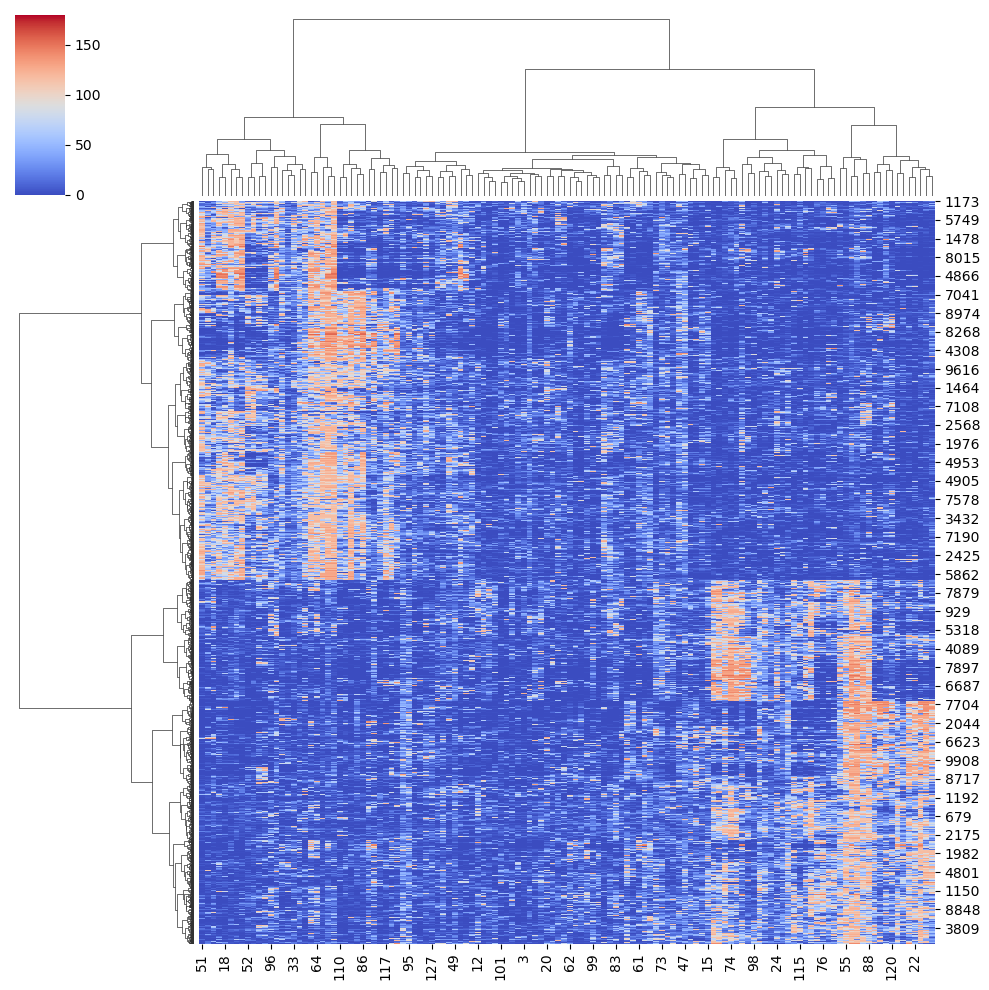

In [5]:
sns.clustermap(xb, metric='euclidean', cmap='coolwarm', method='ward', figsize=(10, 10))
plt.show()

In [6]:
tr_data = xb
queries = xq
sample_query = xq[0]
sample_query_snorm = np.sum(np.square(sample_query))

In [7]:
class PQ:
    def __init__(self, M: int = 8, K: int = 256, kmeans_iter: int = 300,
                 kmeans_minit:str = "k-means++", seed:int = None):
        """
        Product Quantization (PQ) implementation.

        Attributes:
            M (int): Number of subspaces.
            K (int): Number of clusters per subspace.
            kmeans_iter (int): Maximum number of iterations for KMeans.
            kmeans_minit (str): Method for KMeans initialization.
            seed (int): Random seed.
            code_inttype (numpy.dtype): Integer type for storing codes.
            codebook (numpy.ndarray): Cluster centroids for each subspace.
            Ds (int): Dimension of each subspace.
            D (int): Original feature dimension.
            pqcode (numpy.ndarray): Quantized representation of the data.
            avg_dist (numpy.ndarray): Average distortion for each cluster in each subspace.
        """

        self.M = M
        self.K = K
        self.kmeans_iter = kmeans_iter
        self.kmeans_minit = kmeans_minit
        self.seed = seed

        K_bits = np.log2(self.K-1)
        if K_bits <= 8:
            self.code_inttype = np.uint8
        elif K_bits <= 16:
            self.code_inttype = np.uint16
        elif K_bits <= 32:
            self.code_inttype = np.uint32
        else:
            self.code_inttype = np.uint64

        self.codebook = None
        self.Ds = None
        self.pqcode = None
        self.avg_dist = None

    def train(self, data: np.ndarray, add:bool = True,
              compute_distortions:bool = False, verbose:bool = False) -> None:
        """ Train the quantizer on the given data."""
        
        self.D = data.shape[1]
        assert self.D % self.M == 0, "Feature dimension must be divisible by the number of subspaces (M)."
        self.Ds = int(self.D / self.M)
        self.codebook = np.empty((self.M, self.K, self.Ds), np.float32)
        self.pqcode = None # if train is called twice, previous codes are discarded
        self.avg_dist = None
        
        if add:
            self.pqcode = np.empty((data.shape[0], self.M), self.code_inttype)
            if compute_distortions:
                self.avg_dist = np.zeros((self.M, self.K), np.float32)

        for m in range(self.M):
            data_sub = data[:, m*self.Ds : (m+1)*self.Ds]
            km = KMeans(n_clusters=self.K, init=self.kmeans_minit, n_init=1,
                random_state=self.seed, max_iter=self.kmeans_iter).fit(data_sub)
            
            if verbose:
                print(f"KMeans on subspace {m+1} converged in {km.n_iter_} iterations.")
            
            self.codebook[m] = km.cluster_centers_
            if add:
                self.pqcode[:, m], _ = vq(data_sub, self.codebook[m])
                if compute_distortions:
                    for k in range(self.K):
                        dist = cdist(data_sub[self.pqcode[:, m] == k], [self.codebook[m][k]], 'sqeuclidean')
                        self.avg_dist[m, k] = np.mean(dist)

    # NOTE: una sola volta
    def add(self, data: np.ndarray, compute_distortions:bool = False) -> None:
        """ Add data to the quantizer."""

        assert self.codebook is not None, "The quantizer must be trained before adding data."
        assert data.shape[1] == self.D, "Data dimensions must match trained data dimensions."

        pqcode = self.compress(data)
        self.pqcode = pqcode # if self.pqcode is None else np.vstack((self.pqcode, pqcode))

        if compute_distortions: # recomputed if we train on subspace and add other data
            self.avg_dist = np.zeros((self.M, self.K), np.float32)
            for m in range(self.M):
                data_sub = data[:, m*self.Ds : (m+1)*self.Ds]
                for k in range(self.K):
                    dist = cdist(data_sub[self.pqcode[:, m] == k], [self.codebook[m][k]], 'sqeuclidean')
                    self.avg_dist[m, k] = np.mean(dist)

    def compress(self, data: np.ndarray) -> np.ndarray:
        """ Compress data using the trained quantizer."""

        assert self.codebook is not None, "The quantizer must be trained before compressing."
        assert data.shape[1] == self.D, "Data dimensions must match trained data dimensions."

        compressed = np.empty((data.shape[0], self.M), self.code_inttype)
        for m in range(self.M):
            data_sub = data[:, m*self.Ds : (m+1)*self.Ds]
            compressed[:, m], _ = vq(data_sub, self.codebook[m])
        return compressed
    
    def decompress(self, codes: np.ndarray) -> np.ndarray:
        """ Decompress codes using the trained quantizer."""

        assert self.codebook is not None, "The quantizer must be trained before decompressing."
        assert codes.shape[1] == self.M, "Data dimensions must match trained data dimensions."

        decompressed = np.empty((codes.shape[0], self.D), np.float32)
        for m in range(self.M):
            decompressed[:, m*self.Ds : (m+1)*self.Ds] = self.codebook[m][codes[:, m]]
        return decompressed

    def search(self, query: np.ndarray, subset: np.ndarray = None,
               asym:bool = True, correct:bool = False, sort:bool = True) -> tuple[np.ndarray, np.ndarray]:
        """ Search for the nearest neighbors of the query in the quantized data."""

        assert self.codebook is not None, "The quantizer must be trained before searching."
        assert self.pqcode is not None, "Vectors must be added before searching."
        assert (not correct) or (self.avg_dist is not None), "Distorsion must be computed before correcting."
        assert len(query) == self.D, "Query dimensions must match trained data dimensions."
        assert (subset is None) or (subset.shape[0] <= self.pqcode.shape[0]), "Subset size must be less or equal to the number of added vectors."

        if subset is None:
            subset = slice(None)

        dist_table = np.empty((self.M, self.K), np.float32)
        for m in range(self.M):
            query_sub = query[m*self.Ds : (m+1)*self.Ds]
            if not asym:
                query_sub_code, _ = vq([query_sub], self.codebook[m])
                query_sub = self.codebook[m][query_sub_code[0]]
            dist_table[m, :] = cdist([query_sub], self.codebook[m], 'sqeuclidean')[0]
            if correct:
                dist_table[m, :] += self.avg_dist[m]
                if not asym:
                    dist_table[m, query_sub_code] += self.avg_dist[m, query_sub_code]

        dist = np.sum(dist_table[range(self.M), self.pqcode[subset]], axis=1)
        
        if sort:
            return dist, np.argsort(dist)
        return dist, None

In [8]:
class IVF:
    def __init__(self, Kp: int = 1024, M:int = 8, K:int = 256,
                 kmeans_iter:int = 300, kmeans_minit:str = "k-means++",
                 seed:int = None):
        """
        Inverted File (IVF) implementation with Product Quantization (PQ).
    
        Attributes:
            Kp (int): Number of clusters for the coarse quantizer.
            kmeans_iter (int): Maximum number of iterations for KMeans.
            kmeans_minit (str): Method for KMeans initialization.
            seed (int, optional): Random seed.
            ivf (list of np.ndarray): Inverted index storing data indices assigned to each centroid.
            num_els (int): Total number of vectors added to the index.
            centroids (np.ndarray): Coarse quantizer cluster centroids.
            pq (PQ): Product Quantizer instance for quantizing residuals.
        """

        self.Kp = Kp
        self.kmeans_iter = kmeans_iter
        self.kmeans_minit = kmeans_minit
        self.seed = seed
        self.ivf = None
        self.num_els = 0
        self.centroids = None
        self.pq = PQ(M=M, K=K, kmeans_iter=self.kmeans_iter,
                     kmeans_minit=self.kmeans_minit, seed=None)

    def train(self, data: np.ndarray, add:bool = True,
              compute_distortions:bool = False, verbose:bool = False) -> None:
        """Train the IVF on the given data."""
        
        assert data.shape[0] > self.Kp, "Number of vectors must be greater than the number of centroids."
        
        self.num_els = 0
        self.centroids = None
        self.ivf = None

        km = KMeans(n_clusters=self.Kp, init=self.kmeans_minit, n_init=1,
            random_state=self.seed, max_iter=self.kmeans_iter).fit(data)
        if verbose:
            print(f"KMeans for IVF converged in {km.n_iter_} iterations.")
        
        self.centroids = km.cluster_centers_
        labels, _ = vq(data, self.centroids)

        if add:
            self.ivf = [np.where(labels == i)[0] for i in range(self.Kp)]
            self.num_els = data.shape[0]
        
        residuals = data - self.centroids[labels]
        self.pq.train(residuals, add=add, compute_distortions=compute_distortions,
                      verbose=verbose)

    # NOTE: una sola volta
    def add(self, data: np.ndarray, compute_distortions:bool = False) -> None:
        """Add data to the IVF structure."""
        
        assert self.centroids is not None, "The index must be created before adding data."
        assert data.shape[1] == self.pq.D, "Data dimensions must match trained data dimensions."

        labels, _ = vq(data, self.centroids)
        self.ivf = [np.where(labels == i)[0] for i in range(self.Kp)]
        self.num_els = data.shape[0]
        
        residuals = data - self.centroids[labels]
        self.pq.add(residuals, compute_distortions=compute_distortions)

        # for i in range(self.Kp):
        #     els_i = np.where(labels == i)[0]
        #     if els_i.shape[0] > 0:
        #         self.ivf[i] = np.hstack((self.ivf[i], els_i))

    def search(self, query: np.ndarray, w:int = 8, asym:bool = True,
               correct:bool = False, sort:bool = True) -> tuple[np.ndarray, np.ndarray]:
        """Search for the closest vectors to the query in the IVF index."""
        
        assert w <= self.Kp, "Number of centroids to visit must be less or equal to the number of centroids."
        assert self.centroids is not None, "The index must be created before searching."
        assert self.ivf is not None, "Vectors must be added before searching."
        assert len(query) == self.pq.D, "Query dimensions must match trained data dimensions."

        dist2centroids = cdist([query], self.centroids)[0]
        sorted_centroids = np.argsort(dist2centroids)
        els_per_centroid = np.array([len(self.ivf[centroid]) for centroid in sorted_centroids])
        num_els = np.sum(els_per_centroid[:w])
        dists = np.empty(num_els, np.float32)
        els = np.empty(num_els, np.int64)
        
        for i in range(w):
            query_res = query - self.centroids[sorted_centroids[i]]
            curr_docs = self.ivf[sorted_centroids[i]]
            if curr_docs.shape[0] == 0:
                continue
            curr_dist, _ = self.pq.search(query_res, subset=curr_docs, asym=asym, correct=correct, sort=False)
            num_prev_docs = np.sum(els_per_centroid[:i])
            num_curr_docs = els_per_centroid[i]
            dists[num_prev_docs:num_prev_docs+num_curr_docs] = curr_dist
            els[num_prev_docs:num_prev_docs+num_curr_docs] = curr_docs

        if sort:
            sorted_idx = np.argsort(dists)
            dists = dists[sorted_idx]
            els = els[sorted_idx]
        
        return dists, els

In [9]:
class ExactSearch:
    def __init__(self, data: np.ndarray):
        """
        Implements exact search.
        
        Attributes:
            data (np.ndarray): The dataset in which to search.
        """
        self.data = data

    def search(self, query: np.ndarray, sort:bool = True) -> tuple[np.ndarray, np.ndarray]:
        """Searches for the closest vectors to the query."""
        
        assert len(query) == self.data.shape[1], "Query dimensions must match dataset dimensions."

        dist = np.sum((self.data - query)**2, axis=1)   

        if sort:
            return dist, np.argsort(dist)
        
        return dist, None

In [10]:
def recall_at_r(ranking, exact_ranking, r):
    """Compute the Recall@R."""
    return len(set(ranking[:r]) & set(exact_ranking[:r])) / r

def AP(ranking, exact_ranking):
    """Compute the Average Precision."""
    ap = 0
    num_rel = 0
    for i, idx in enumerate(ranking):
        if idx in exact_ranking:
            num_rel += 1
            ap += num_rel / (i+1)
    return ap / num_rel

def NMSE(original_data, decompressed_data):
    """Compute the Normalized Mean Squared Error."""
    squared_error = np.sum((original_data - decompressed_data)**2, axis=1)
    squared_norm = np.sum(np.square(original_data), axis=1)
    return np.mean(squared_error / squared_norm)

In [11]:
M = 8
K = 256
pq = PQ(M=M, K=K, seed=RANDOM_SEED)

print("Training the PQ quantizer...")
start_training = time.time()
pq.train(tr_data, add=True, compute_distortions=False, verbose=True)
training_time = time.time() - start_training

print("--------------------")
print(f"Training time: {training_time:.2f} s")
print(f"Compressed data shape: {pq.pqcode.shape}")
print(f"Compressed data size: {pq.pqcode.nbytes} bytes")
print(f"Original data size: {tr_data.nbytes} bytes")
print(f"Compression factor: {tr_data.nbytes / pq.pqcode.nbytes:.2f}")

compressed_tr = pq.compress(tr_data)
decompressed_tr = pq.decompress(compressed_tr) 
error_tr = NMSE(tr_data, decompressed_tr)
print(f"Reconstruction error on training data (NMSE): {error_tr:.3f}")

compressed_ts = pq.compress(queries)
decompressed_ts = pq.decompress(compressed_ts)
error_ts = NMSE(queries, decompressed_ts)
print(f"Reconstruction error on testing data (NMSE): {error_ts:.3f}")

start_training = time.time()
pq.train(tr_data, add=True, compute_distortions=True)
training_time = time.time() - start_training

print("--------------------")
print(f"Training time with average distortion computation: {training_time:.2f} s")
print(f"Compressed data shape with average distortion: {pq.pqcode.shape} + {pq.avg_dist.shape}")
print(f"Compressed data with average distortion size: {pq.pqcode.nbytes + pq.avg_dist.nbytes} bytes")
print(f"Original data size: {tr_data.nbytes} bytes")
print(f"Compression factor with average distortion: {tr_data.nbytes / (pq.pqcode.nbytes + pq.avg_dist.nbytes):.2f}")

Training the PQ quantizer...
KMeans on subspace 1 converged in 25 iterations.
KMeans on subspace 2 converged in 38 iterations.
KMeans on subspace 3 converged in 29 iterations.
KMeans on subspace 4 converged in 24 iterations.
KMeans on subspace 5 converged in 29 iterations.
KMeans on subspace 6 converged in 36 iterations.
KMeans on subspace 7 converged in 24 iterations.
KMeans on subspace 8 converged in 36 iterations.
--------------------
Training time: 3.87 s
Compressed data shape: (10000, 8)
Compressed data size: 80000 bytes
Original data size: 5120000 bytes
Compression factor: 64.00
Reconstruction error on training data (NMSE): 0.084
Reconstruction error on testing data (NMSE): 0.095
--------------------
Training time with average distortion computation: 3.87 s
Compressed data shape with average distortion: (10000, 8) + (8, 256)
Compressed data with average distortion size: 88192 bytes
Original data size: 5120000 bytes
Compression factor with average distortion: 58.06


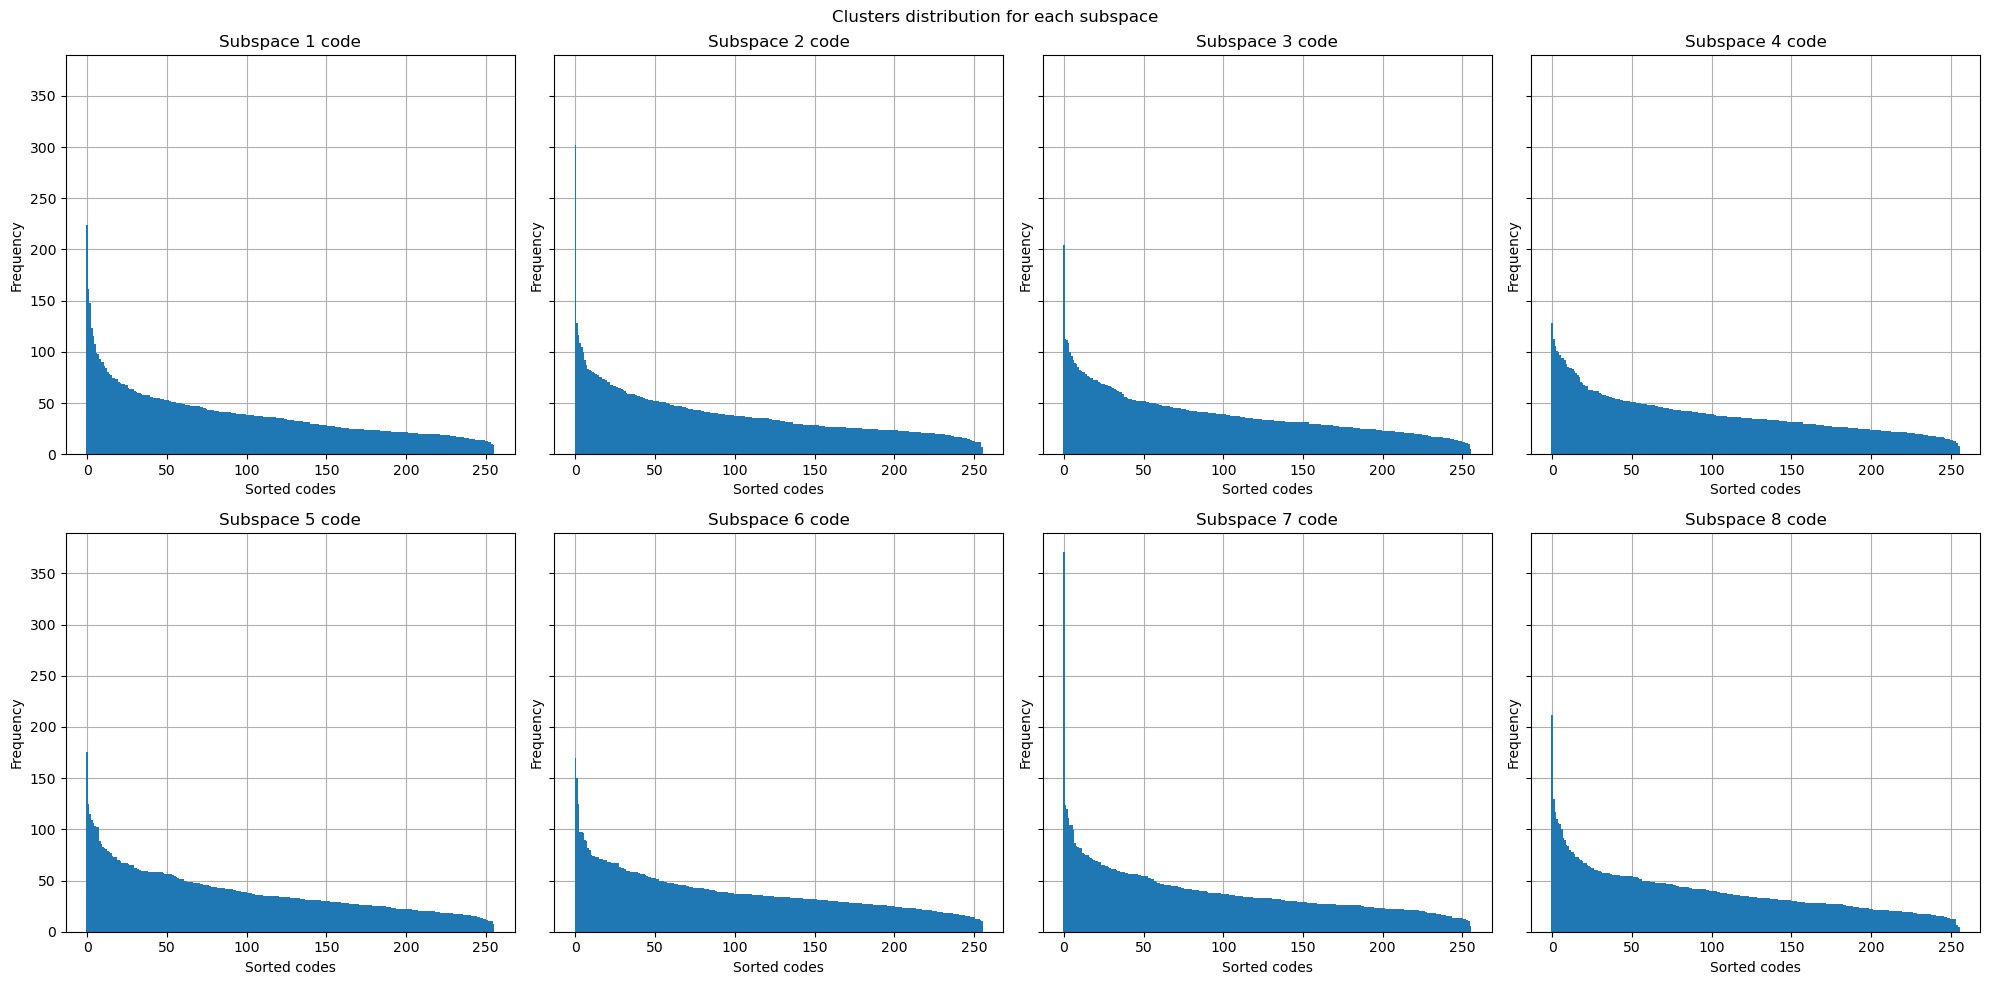

In [12]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharey=True)
id = 0
for m in range(pq.M):
    hist, bins = np.histogram(pq.pqcode[:, m], bins=range(pq.K+1))
    hist = sorted(hist, reverse=True)
    axs[int(id/4)][id%4].bar(bins[:-1], hist, width=1)
    axs[int(id/4)][id%4].set_title(f"Subspace {m+1} code")
    axs[int(id/4)][id%4].set_xlabel("Sorted codes")
    axs[int(id/4)][id%4].set_ylabel("Frequency")
    axs[int(id/4)][id%4].grid()
    axs[int(id/4)][id%4].set_axisbelow(True)
    id += 1

plt.suptitle("Clusters distribution for each subspace")
plt.tight_layout()
plt.show()

In [13]:
asym_pq_dists, asym_ranking = pq.search(sample_query, subset=None, asym=True, correct=False)
asym_pq_corr_dists, asym_corr_ranking = pq.search(sample_query, subset=None, asym=True, correct=True)
sym_pq_dists, sym_ranking = pq.search(sample_query, subset=None, asym=False, correct=False)
sym_pq_corr_dists, sym_corr_ranking = pq.search(sample_query, subset=None, asym=False, correct=True)
es = ExactSearch(tr_data)
exact_dists, exact_ranking = es.search(sample_query)

In [14]:
# check if computed exact ranking is equal to ground truth
np.all(gt[0][:100]==exact_ranking[:100])

True

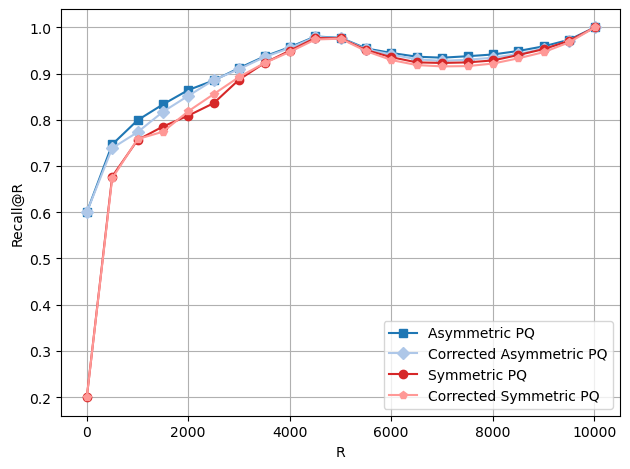

In [15]:
recalls = {"Asymmetric PQ": [], "Corrected Asymmetric PQ": [], "Symmetric PQ": [], "Corrected Symmetric PQ": []}
rs = range(5, 10000 + 500, 500)
for r in rs:
    recalls["Asymmetric PQ"].append(recall_at_r(asym_ranking, exact_ranking, r))
    recalls["Corrected Asymmetric PQ"].append(recall_at_r(asym_corr_ranking, exact_ranking, r))
    recalls["Symmetric PQ"].append(recall_at_r(sym_ranking, exact_ranking, r))
    recalls["Corrected Symmetric PQ"].append(recall_at_r(sym_corr_ranking, exact_ranking, r))

plt.plot(rs, recalls["Asymmetric PQ"], '-s', label="Asymmetric PQ", color=matplotlib.colormaps["tab20"](0))
plt.plot(rs, recalls["Corrected Asymmetric PQ"], '-D', label="Corrected Asymmetric PQ", color=matplotlib.colormaps["tab20"](1))
plt.plot(rs, recalls["Symmetric PQ"], '-o', label="Symmetric PQ", color=matplotlib.colormaps["tab20"](6))
plt.plot(rs, recalls["Corrected Symmetric PQ"], '-p', label="Corrected Symmetric PQ", color=matplotlib.colormaps["tab20"](7))
plt.xlabel('R')
plt.ylabel('Recall@R')
plt.grid(zorder=0)
plt.tight_layout()
plt.legend();

In [16]:
APs = {}
APs["Asymmetric PQ"] = AP(asym_ranking[:50], exact_ranking[:50])
APs["Symmetric PQ"] = AP(sym_ranking[:50], exact_ranking[:50])
pd.DataFrame(APs, index=["AP"])

,Asymmetric PQ,Symmetric PQ
AP,0.846393,0.748325


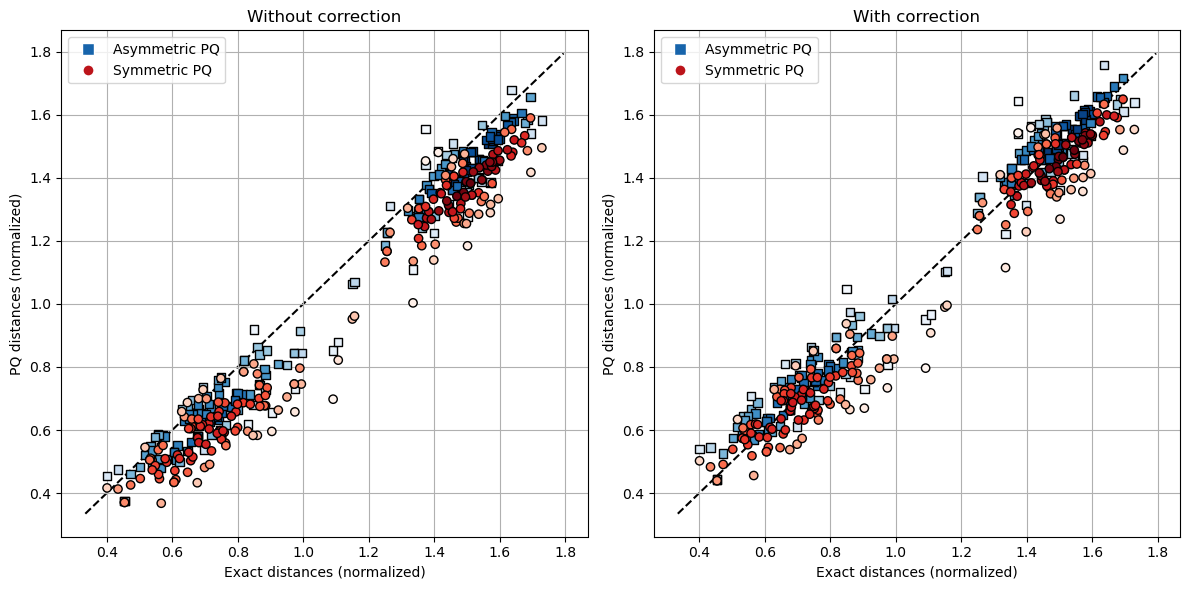

In [17]:
def plot_exact_vs_estimated(axs, exact_dists, asym_pq_dists, sym_pq_dists, query):
    query_snorm = np.sum(np.square(query))
    exact_dists = exact_dists / query_snorm
    asym_pq_dists = asym_pq_dists / query_snorm
    sym_pq_dists = sym_pq_dists / query_snorm
    
    xy_asym = np.vstack([exact_dists, asym_pq_dists])
    kernel_asym = gaussian_kde(xy_asym)(xy_asym)
    axs.scatter(
        exact_dists,
        asym_pq_dists,
        c=kernel_asym,
        cmap="Blues", edgecolor='black', label="Asymmetric PQ",
        zorder=2, marker='s')

    xy_sym = np.vstack([exact_dists, sym_pq_dists])
    kernel_sym = gaussian_kde(xy_sym)(xy_sym)
    axs.scatter(
        exact_dists,
        sym_pq_dists,
        c=kernel_sym,
        cmap="Reds", edgecolor='black', label="Symmetric PQ",
        zorder=2, marker='o')

    axs.set_xlabel("Exact distances (normalized)")
    axs.set_ylabel("PQ distances (normalized)")
    xpoints = axs.get_xlim()
    axs.plot(xpoints, xpoints, linestyle='--', color='black', zorder=1)
    axs.grid(zorder=0)
    legend_elements = [
        Line2D([0], [0], marker='s', color='w', label='Asymmetric PQ', markersize=8,
            markerfacecolor=matplotlib.colormaps['Blues'](0.8)),
        Line2D([0], [0], marker='o', color='w', label='Symmetric PQ', markersize=8,
            markerfacecolor=matplotlib.colormaps['Reds'](0.8))
    ] # TODO: white border is missing
    axs.legend(handles=legend_elements);

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
SAMPLE_SIZE = 200
sample = np.random.randint(0, 1000, SAMPLE_SIZE)
plot_exact_vs_estimated(axs[0], exact_dists[sample], asym_pq_dists[sample], sym_pq_dists[sample], sample_query)
axs[0].set_title("Without correction")
plot_exact_vs_estimated(axs[1], exact_dists[sample], asym_pq_corr_dists[sample], sym_pq_corr_dists[sample], sample_query)
axs[1].set_title("With correction");
plt.tight_layout()

In [18]:
asym_diffs = np.zeros((10000*queries.shape[0]))
asym_diffs_corr = np.zeros((10000*queries.shape[0]))
sym_diffs = np.zeros((10000*queries.shape[0]))
sym_diffs_corr = np.zeros((10000*queries.shape[0]))

R = [1, 10, 100, 1000, 10000]
asym_recall = np.zeros((len(queries), len(R)))
asym_corr_recall = np.zeros((len(queries), len(R)))
sym_recall = np.zeros((len(queries), len(R)))
sym_corr_recall = np.zeros((len(queries), len(R)))

exact_nearest = np.empty(len(queries))
mean_es_time = 0

for i, query in enumerate(queries):
    asym_d_est, asym_rank = pq.search(query, subset=None, asym=True, correct=False)
    asym_d_est_corr, asym_corr_rank = pq.search(query, subset=None, asym=True, correct=True)
    sym_d_est, sym_rank = pq.search(query, subset=None, asym=False, correct=False)
    sym_d_est_corr, sym_corr_rank = pq.search(query, subset=None, asym=False, correct=True)
    start_search_time = time.time()
    d, rank = es.search(query)
    mean_es_time += time.time() - start_search_time
    exact_nearest[i] = rank[0]
    query_norm = np.sum(np.square(query))
    asym_diffs[i*10000:(i+1)*10000] = (asym_d_est-d) / query_norm
    asym_diffs_corr[i*10000:(i+1)*10000] = (asym_d_est_corr-d) / query_norm
    sym_diffs[i*10000:(i+1)*10000] = (sym_d_est-d) / query_norm
    sym_diffs_corr[i*10000:(i+1)*10000] = (sym_d_est_corr-d) / query_norm

    for j, r in enumerate(R):
        asym_recall[i][j] = exact_nearest[i] in asym_rank[:r]
        asym_corr_recall[i][j] = exact_nearest[i] in asym_corr_rank[:r]
        sym_recall[i][j] = exact_nearest[i] in sym_rank[:r]
        sym_corr_recall[i][j] = exact_nearest[i] in sym_corr_rank[:r]

mean_es_time /= len(queries)

asym_recall_mean = np.mean(asym_recall, axis=0)
asym_corr_recall_mean = np.mean(asym_corr_recall, axis=0)
sym_recall_mean = np.mean(sym_recall, axis=0)
sym_corr_recall_mean = np.mean(sym_corr_recall, axis=0)

asym_recall_yerr = [
    asym_recall_mean - np.min(asym_recall, axis=0),
    np.max(asym_recall, axis=0) - asym_recall_mean
]
asym_corr_recall_yerr = [
    asym_corr_recall_mean - np.min(asym_corr_recall, axis=0),
    np.max(asym_corr_recall, axis=0) - asym_corr_recall_mean
]
sym_recall_yerr = [
    sym_recall_mean - np.min(sym_recall, axis=0),
    np.max(sym_recall, axis=0) - sym_recall_mean
]
sym_corr_recall_yerr = [
    sym_corr_recall_mean - np.min(sym_corr_recall, axis=0),
    np.max(sym_corr_recall, axis=0) - sym_corr_recall_mean
]

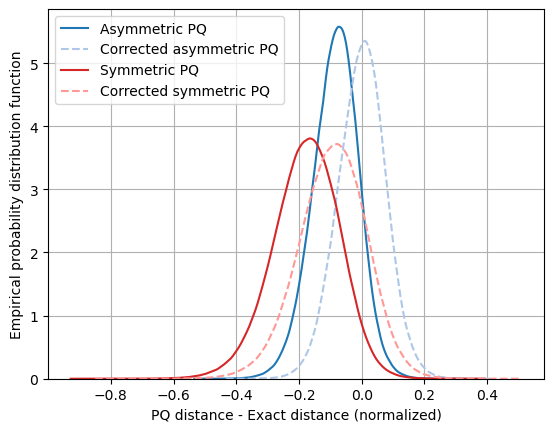

In [19]:
sns.kdeplot(asym_diffs, label="Asymmetric PQ", color=matplotlib.colormaps["tab20"](0))
sns.kdeplot(asym_diffs_corr, label="Corrected asymmetric PQ", color=matplotlib.colormaps["tab20"](1), linestyle='dashed')
sns.kdeplot(sym_diffs, label="Symmetric PQ", color=matplotlib.colormaps["tab20"](6))
sns.kdeplot(sym_diffs_corr, label="Corrected symmetric PQ", color=matplotlib.colormaps["tab20"](7), linestyle='dashed')
plt.xlabel("PQ distance - Exact distance (normalized)")
plt.ylabel("Empirical probability distribution function")
plt.legend();
plt.grid()

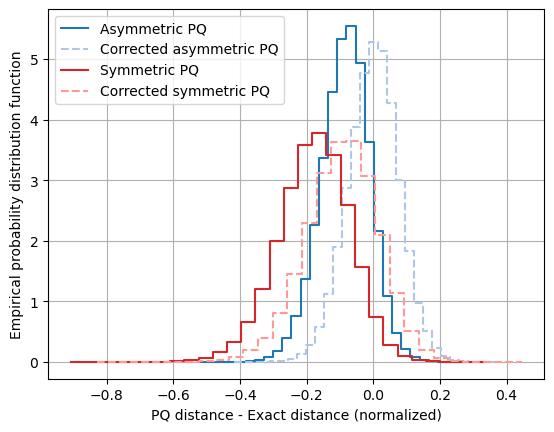

In [20]:
bins = 30

hist_asym, bin_edges_asym = np.histogram(asym_diffs, bins=bins, density=True)
plt.step(bin_edges_asym[:-1], hist_asym, where='post', label="Asymmetric PQ", color=matplotlib.colormaps["tab20"](0))

hist_asym_corr, bin_edges_asym_corr = np.histogram(asym_diffs_corr, bins=bins, density=True)
plt.step(bin_edges_asym_corr[:-1], hist_asym_corr, where='post', label="Corrected asymmetric PQ", color=matplotlib.colormaps["tab20"](1), linestyle='dashed')

hist_sym, bin_edges_sym = np.histogram(sym_diffs, bins=bins, density=True)
plt.step(bin_edges_sym[:-1], hist_sym, where='post', label="Symmetric PQ", color=matplotlib.colormaps["tab20"](6))

hist_sym_corr, bin_edges_sym_corr = np.histogram(sym_diffs_corr, bins=bins, density=True)
plt.step(bin_edges_sym_corr[:-1], hist_sym_corr, where='post', label="Corrected symmetric PQ", color=matplotlib.colormaps["tab20"](7), linestyle='dashed')

plt.xlabel("PQ distance - Exact distance (normalized)")
plt.ylabel("Empirical probability distribution function")
plt.legend()
plt.grid()

In [21]:
asym_diff_var = np.var(asym_diffs)
asym_corr_diff_var = np.var(asym_diffs_corr)
sym_diff_var = np.var(sym_diffs)
sym_corr_diff_var = np.var(sym_diffs_corr)
pd.DataFrame({
    "Asymmetric PQ": [asym_diff_var],
    "Corrected asymmetric PQ": [asym_corr_diff_var],
    "Symmetric PQ": [sym_diff_var],
    "Corrected symmetric PQ": [sym_corr_diff_var],
    }, index=["Variance of error"])

,Asymmetric PQ,Corrected asymmetric PQ,Symmetric PQ,Corrected symmetric PQ
Variance of error,0.005427,0.005875,0.011278,0.011749


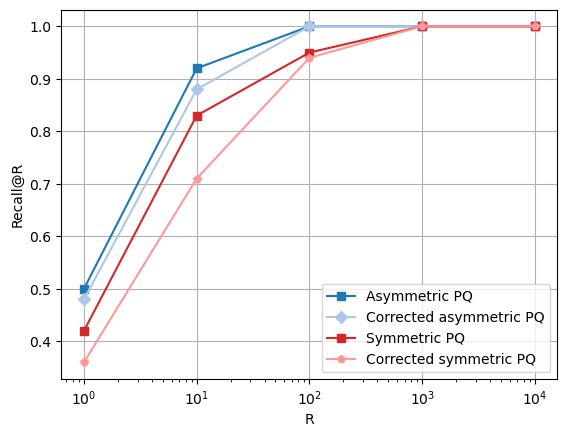

In [22]:
# plt.errorbar(R, asym_recall_mean, yerr=asym_recall_yerr, fmt='-s', label="Asymmetric PQ", color=matplotlib.colormaps["tab20"](0))
# plt.errorbar(R, asym_corr_recall_mean, yerr=asym_corr_recall_yerr, fmt='-o', label="Corrected asymmetric PQ", color=matplotlib.colormaps["tab20"](1))
# plt.errorbar(R, sym_recall_mean, yerr=sym_recall_yerr, fmt='-s', label="Symmetric PQ", color=matplotlib.colormaps["tab20"](6))
# plt.errorbar(R, sym_corr_recall_mean, yerr=sym_corr_recall_yerr, fmt='-o', label="Corrected symmetric PQ", color=matplotlib.colormaps["tab20"](7))
plt.plot(R, asym_recall_mean, '-s', label="Asymmetric PQ", color=matplotlib.colormaps["tab20"](0))
plt.plot(R, asym_corr_recall_mean, '-D', label="Corrected asymmetric PQ", color=matplotlib.colormaps["tab20"](1))
plt.plot(R, sym_recall_mean, '-s', label="Symmetric PQ", color=matplotlib.colormaps["tab20"](6))
plt.plot(R, sym_corr_recall_mean, '-p', label="Corrected symmetric PQ", color=matplotlib.colormaps["tab20"](7))
plt.xscale('log')
plt.xlabel('R')
plt.ylabel('Recall@R')
plt.legend()
plt.grid()

In [23]:
ivf = IVF(Kp=1024, M=M, K=K, seed=RANDOM_SEED)
start_indexing = time.time()
ivf.train(tr_data, add=True, compute_distortions=True)
end_indexing = time.time() - start_indexing

print(f"Indexing + compression time (with avg dist computation): {end_indexing:.2f} s")

Indexing + compression time (with avg dist computation): 7.78 s


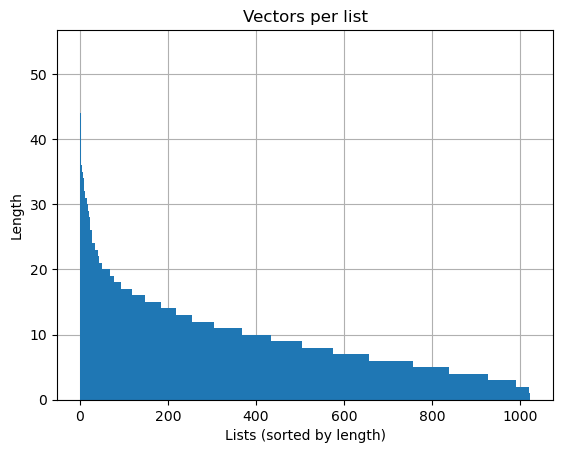

In [24]:
els_per_cluster = []
for i in range(ivf.Kp):
    els_per_cluster.append(len(ivf.ivf[i]))
fig, axs = plt.subplots(1)
axs.bar(range(ivf.Kp), sorted(els_per_cluster, reverse=True), width=1.0)
axs.set_xlabel("Lists (sorted by length)")
axs.set_ylabel("Length")
axs.set_title("Vectors per list")
axs.set_axisbelow(True)
axs.grid()

In [25]:
ivf_asym_recall = np.full((len(queries), len(R)), np.nan)
ivf_asym_corr_recall = np.full((len(queries), len(R)), np.nan)
ivf_sym_recall = np.full((len(queries), len(R)), np.nan)
ivf_sym_corr_recall = np.full((len(queries), len(R)), np.nan)

for i, query in enumerate(queries):
    ivf_asym_d_est, ivf_asym_rank = ivf.search(query, w=8, asym=True, correct=False)
    ivf_asym_d_est_corr, ivf_asym_corr_rank = ivf.search(query, w=8, asym=True, correct=True)
    ivf_sym_d_est, ivf_sym_rank = ivf.search(query, w=8, asym=False, correct=False)
    ivf_sym_d_est_corr, ivf_sym_corr_rank = ivf.search(query, w=8, asym=False, correct=True)
    query_norm = np.sum(np.square(query))

    for j, r in enumerate(R):
        if r < len(ivf_asym_rank):
            ivf_asym_recall[i][j] = exact_nearest[i] in ivf_asym_rank[:r]
        if r < len(ivf_asym_corr_rank):
            ivf_asym_corr_recall[i][j] = exact_nearest[i] in ivf_asym_corr_rank[:r]
        if r < len(ivf_sym_rank):
            ivf_sym_recall[i][j] = exact_nearest[i] in ivf_sym_rank[:r]
        if r < len(ivf_sym_corr_rank):
            ivf_sym_corr_recall[i][j] = exact_nearest[i] in ivf_sym_corr_rank[:r]

ivf_asym_recall_mean = np.nanmean(ivf_asym_recall, axis=0)
ivf_asym_corr_recall_mean = np.nanmean(ivf_asym_corr_recall, axis=0)
ivf_sym_recall_mean = np.nanmean(ivf_sym_recall, axis=0)
ivf_sym_corr_recall_mean = np.nanmean(ivf_sym_corr_recall, axis=0)

ivf_asym_recall_yerr = [
    ivf_asym_recall_mean - np.min(ivf_asym_recall, axis=0),
    np.max(ivf_asym_recall, axis=0) - ivf_asym_recall_mean
]
ivf_asym_corr_recall_yerr = [
    ivf_asym_corr_recall_mean - np.min(ivf_asym_corr_recall, axis=0),
    np.max(ivf_asym_corr_recall, axis=0) - ivf_asym_corr_recall_mean
]
ivf_sym_recall_yerr = [
    ivf_sym_recall_mean - np.min(ivf_sym_recall, axis=0),
    np.max(ivf_sym_recall, axis=0) - ivf_sym_recall_mean
]
ivf_sym_corr_recall_yerr = [
    ivf_sym_corr_recall_mean - np.min(ivf_sym_corr_recall, axis=0),
    np.max(ivf_sym_corr_recall, axis=0) - ivf_sym_corr_recall_mean
]

/var/folders/8n/f3j9y6bd3zd_kp83y0vvn_b80000gn/T/ipykernel_3638/1195348626.py:23: RuntimeWarning: Mean of empty slice
  ivf_asym_recall_mean = np.nanmean(ivf_asym_recall, axis=0)
/var/folders/8n/f3j9y6bd3zd_kp83y0vvn_b80000gn/T/ipykernel_3638/1195348626.py:24: RuntimeWarning: Mean of empty slice
  ivf_asym_corr_recall_mean = np.nanmean(ivf_asym_corr_recall, axis=0)
/var/folders/8n/f3j9y6bd3zd_kp83y0vvn_b80000gn/T/ipykernel_3638/1195348626.py:25: RuntimeWarning: Mean of empty slice
  ivf_sym_recall_mean = np.nanmean(ivf_sym_recall, axis=0)
/var/folders/8n/f3j9y6bd3zd_kp83y0vvn_b80000gn/T/ipykernel_3638/1195348626.py:26: RuntimeWarning: Mean of empty slice
  ivf_sym_corr_recall_mean = np.nanmean(ivf_sym_corr_recall, axis=0)


These warnings occur when the number of retrieved elements is less than the value in R.

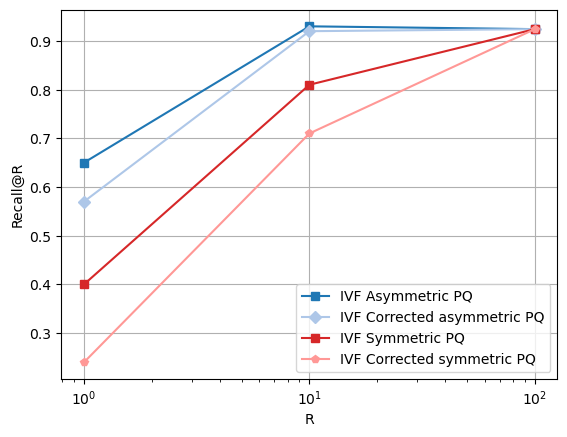

In [26]:
# plt.errorbar(R, ivf_asym_recall_mean, yerr=ivf_asym_recall_yerr, fmt='-s', label="IVF Asymmetric PQ", color=matplotlib.colormaps["tab20"](0))
# plt.errorbar(R, ivf_asym_corr_recall_mean, yerr=ivf_asym_corr_recall_yerr, fmt='-o', label="IVF Corrected asymmetric PQ", color=matplotlib.colormaps["tab20"](1))
# plt.errorbar(R, ivf_sym_recall_mean, yerr=ivf_sym_recall_yerr, fmt='-s', label="IVF Symmetric PQ", color=matplotlib.colormaps["tab20"](6))
# plt.errorbar(R, ivf_sym_corr_recall_mean, yerr=ivf_sym_corr_recall_yerr, fmt='-o', label="IVF Corrected symmetric PQ", color=matplotlib.colormaps["tab20"](7))
plt.plot(R, ivf_asym_recall_mean, '-s', label="IVF Asymmetric PQ", color=matplotlib.colormaps["tab20"](0))
plt.plot(R, ivf_asym_corr_recall_mean, '-D', label="IVF Corrected asymmetric PQ", color=matplotlib.colormaps["tab20"](1))
plt.plot(R, ivf_sym_recall_mean, '-s', label="IVF Symmetric PQ", color=matplotlib.colormaps["tab20"](6))
plt.plot(R, ivf_sym_corr_recall_mean, '-p', label="IVF Corrected symmetric PQ", color=matplotlib.colormaps["tab20"](7))
plt.xscale('log')
plt.xlabel('R')
plt.ylabel('Recall@R')
plt.legend()
plt.grid()

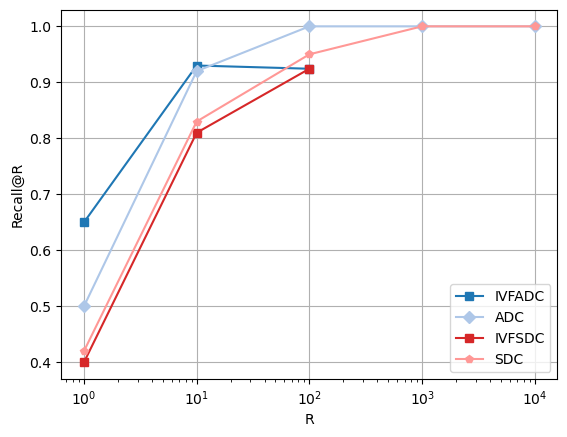

In [27]:
plt.plot(R, ivf_asym_recall_mean, '-s', label="IVFADC", color=matplotlib.colormaps["tab20"](0))
plt.plot(R, asym_recall_mean, '-D', label="ADC", color=matplotlib.colormaps["tab20"](1))
plt.plot(R, ivf_sym_recall_mean, '-s', label="IVFSDC", color=matplotlib.colormaps["tab20"](6))
plt.plot(R, sym_recall_mean, '-p', label="SDC", color=matplotlib.colormaps["tab20"](7))
plt.xscale('log')
plt.xlabel('R')
plt.ylabel('Recall@R')
plt.legend()
plt.grid()

In [28]:
Ms = [1, 2, 4, 8, 16]
Ks = [16, 64, 256, 1024]

training_results = []
search_results = []

for m in Ms:
    for r in Ks:
        print(f"Training PQ with M={m}, K={r}...")
        
        pq = PQ(M=m, K=r, seed=RANDOM_SEED)
        start_training = time.time()
        pq.train(tr_data) # TODO: su tutto?
        training_time = time.time() - start_training
        
        decompressed_tr = pq.decompress(pq.pqcode) 
        tr_NMSE = NMSE(tr_data, decompressed_tr)
        compressed_ts = pq.compress(queries)
        decompressed_ts = pq.decompress(compressed_ts)
        ts_NMSE = NMSE(queries, decompressed_ts)

        code_length = np.log2(r) * m
        curr_training_res = {"M": m, "K": r, "Code length [bits]": code_length,
                  "Training time [s]": training_time, "TR NMSE": tr_NMSE,
                  "TS NMSE": ts_NMSE}
        training_results.append(curr_training_res)
        
        for asym in [True, False]:
            mean_search_time = 0
            recall = 0
            for i, query in enumerate(queries):
                start_search = time.time()
                _, ranking = pq.search(query, subset=None, asym=asym, correct=False)
                mean_search_time += (time.time() - start_search)
                if exact_nearest[i] in ranking[:100]:
                    recall += 1
            mean_search_time /= len(queries)
            recall /= len(queries)
            
            curr_search_res = {"M": m, "K": r, "Code length [bits]": code_length,
                          "Asymmetric Distance": asym,
                          "Mean search time [ms]": mean_search_time*1000,
                          "Recall@100": recall}
            search_results.append(curr_search_res)

training_results = pd.DataFrame(training_results)
search_results = pd.DataFrame(search_results)

Training PQ with M=1, K=16...
Training PQ with M=1, K=64...
Training PQ with M=1, K=256...
Training PQ with M=1, K=1024...
Training PQ with M=2, K=16...
Training PQ with M=2, K=64...
Training PQ with M=2, K=256...
Training PQ with M=2, K=1024...
Training PQ with M=4, K=16...
Training PQ with M=4, K=64...
Training PQ with M=4, K=256...
Training PQ with M=4, K=1024...
Training PQ with M=8, K=16...
Training PQ with M=8, K=64...
Training PQ with M=8, K=256...
Training PQ with M=8, K=1024...
Training PQ with M=16, K=16...
Training PQ with M=16, K=64...
Training PQ with M=16, K=256...
Training PQ with M=16, K=1024...


In [29]:
training_results

,M,K,Code length [bits],Training time [s],TR NMSE,TS NMSE
0,1,16,4.0,0.226928,0.291917,0.295238
1,1,64,6.0,0.653375,0.248438,0.251844
2,1,256,8.0,1.302152,0.207039,0.218702
3,1,1024,10.0,4.068994,0.148821,0.191093
4,2,16,8.0,0.929381,0.271712,0.273710
5,2,64,12.0,1.318531,0.221071,0.230138
6,2,256,16.0,1.988422,0.175090,0.191812
7,2,1024,20.0,4.695811,0.120195,0.166139
8,4,16,16.0,1.534453,0.246781,0.250801
9,4,64,24.0,1.681806,0.187850,0.195577


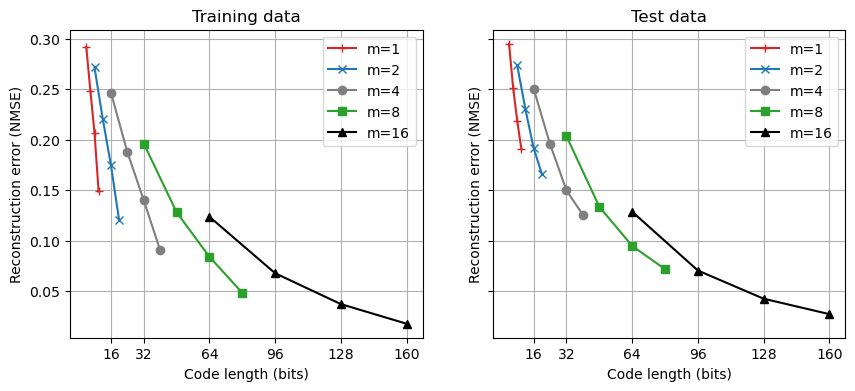

In [30]:
colors = ['tab:red', 'tab:blue', 'tab:gray', 'tab:green', 'black']
markers = ['+', 'x', 'o', 's', '^']

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
for i, m in enumerate(Ms):
    res = training_results[training_results["M"]==m]
    axs[0].plot(res["Code length [bits]"], res["TR NMSE"], marker=markers[i], color=colors[i], label=f"m={m}")
    axs[1].plot(res["Code length [bits]"], res["TS NMSE"], marker=markers[i], color=colors[i], label=f"m={m}")

axs[0].set_xticks([16, 32, 64, 96, 128, 160])
axs[0].set_xlabel("Code length (bits)")
axs[0].set_ylabel("Reconstruction error (NMSE)")
axs[0].set_title("Training data")
axs[0].legend()
axs[0].grid()
axs[1].set_xticks([16, 32, 64, 96, 128, 160])
axs[1].set_xlabel("Code length (bits)")
axs[1].set_ylabel("Reconstruction error (NMSE)")
axs[1].set_title("Test data")
axs[1].legend()
axs[1].grid()

In [31]:
print(f"Mean Exact Search time: {mean_es_time*1000} [ms]")
search_results

Mean Exact Search time: 1.4408469200134277 [ms]


,M,K,Code length [bits],Asymmetric Distance,Mean search time [ms],Recall@100
0,1,16,4.0,True,0.590298,0.14
1,1,16,4.0,False,0.356371,0.18
2,1,64,6.0,True,0.572214,0.38
3,1,64,6.0,False,0.494773,0.42
4,1,256,8.0,True,0.788276,0.78
5,1,256,8.0,False,0.695229,0.69
6,1,1024,10.0,True,0.798790,0.94
7,1,1024,10.0,False,1.053209,0.74
8,2,16,8.0,True,0.712152,0.41
9,2,16,8.0,False,0.649893,0.36


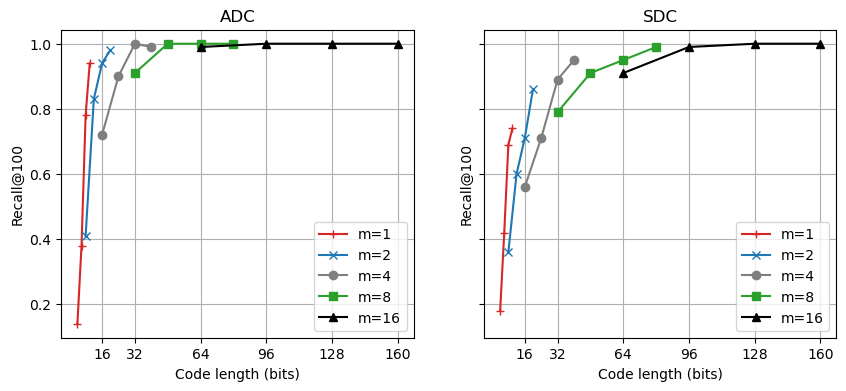

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
for i, m in enumerate(Ms):
    asym_res = search_results[(search_results["M"]==m) &(search_results["Asymmetric Distance"]==True)]
    axs[0].plot(asym_res["Code length [bits]"], asym_res["Recall@100"], marker=markers[i], color=colors[i], label=f"m={m}")
    sym_res = search_results[(search_results["M"]==m) &(search_results["Asymmetric Distance"]==False)]
    axs[1].plot(sym_res["Code length [bits]"], sym_res["Recall@100"], marker=markers[i], color=colors[i], label=f"m={m}")

axs[0].set_xticks([16, 32, 64, 96, 128, 160])
axs[0].set_xlabel("Code length (bits)")
axs[0].set_ylabel("Recall@100")
axs[0].set_title("ADC")
axs[0].legend()
axs[0].grid()
axs[1].set_xticks([16, 32, 64, 96, 128, 160])
axs[1].set_xlabel("Code length (bits)")
axs[1].set_ylabel("Recall@100")
axs[1].set_title("SDC")
axs[1].legend()
axs[1].grid()

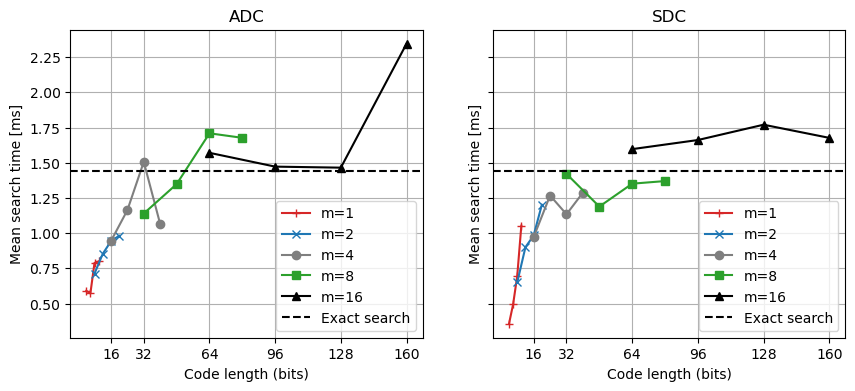

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
for i, m in enumerate(Ms):
    asym_res = search_results[(search_results["M"]==m) &(search_results["Asymmetric Distance"]==True)]
    axs[0].plot(asym_res["Code length [bits]"], asym_res["Mean search time [ms]"], marker=markers[i], color=colors[i], label=f"m={m}")
    sym_res = search_results[(search_results["M"]==m) &(search_results["Asymmetric Distance"]==False)]
    axs[1].plot(sym_res["Code length [bits]"], sym_res["Mean search time [ms]"], marker=markers[i], color=colors[i], label=f"m={m}")

axs[0].axhline(mean_es_time*1000, 0, 32, color='black', linestyle='--', label="Exact search")
axs[1].axhline(mean_es_time*1000, 0, 32, color='black', linestyle='--', label="Exact search")

axs[0].set_xticks([16, 32, 64, 96, 128, 160])
axs[0].set_xlabel("Code length (bits)")
axs[0].set_ylabel("Mean search time [ms]")
axs[0].set_title("ADC")
axs[0].legend()
axs[0].grid()
axs[1].set_xticks([16, 32, 64, 96, 128, 160])
axs[1].set_xlabel("Code length (bits)")
axs[1].set_ylabel("Mean search time [ms]")
axs[1].set_title("SDC")
axs[1].legend()
axs[1].grid()

In [ ]:
# exec time = 20*3=60 min...

K = 256
Ms = [1, 2, 4, 8, 16]
Kps = [1024, 8192]
ws = [1, 8, 64]

ivf_training_results = []
ivf_search_results = []

for m in Ms:
    for Kp in Kps:
        print(f"Training PQ with M={m}, Kp={Kp}...")
        
        ivf = IVF(Kp=Kp, M=m, K=K, seed=RANDOM_SEED)
        start_indexing = time.time()
        ivf.train(tr_data, add=True)
        indexing_time = time.time() - start_indexing

        code_length = np.log2(K) * m
        curr_training_res = {"M": m, "Kp": Kp,
                             "Code length [bits]": code_length,
                             "Indexing time [s]": indexing_time}
        ivf_training_results.append(curr_training_res)
        
        for w in ws:
            if (Kp == 1024 and w == 64) or (Kp == 8192 and w == 1):
                continue
            mean_search_time = 0
            recall = 0
            for i, query in enumerate(queries):
                start_search = time.time()
                _, ranking = ivf.search(query, w=w, asym=True, correct=False)
                mean_search_time += (time.time() - start_search)
                if exact_nearest[i] in ranking[:100]:
                    recall += 1
            mean_search_time /= len(queries)
            recall /= len(queries)
            
            curr_search_res = {"M": m, "Kp": Kp, "w":w,
                               "Code length [bits]": code_length,
                               "Mean search time [ms]": mean_search_time*1000,
                               "Recall@100": recall}
            ivf_search_results.append(curr_search_res)

ivf_training_results = pd.DataFrame(ivf_training_results)
ivf_search_results = pd.DataFrame(ivf_search_results)

In [ ]:
i = 0
for Kp in Kps:
    for w in ws:
        if (Kp == 1024 and w == 64) or (Kp == 8192 and w == 1):
            continue
        res = ivf_search_results[(ivf_search_results["Kp"]==Kp) & (ivf_search_results["w"]==w)]
        plt.plot(res["Code length [bits]"], res["Recall@100"], marker=markers[i], color=colors[i], label=f"Kp={Kp}, w={w}")
        i += 1

plt.xlabel("Code length (bits)")
plt.ylabel("Recall@100")
plt.title("IVFADC")
plt.legend()
plt.grid()

# TODO: eventualmente inserisci in unico plot a confronto con altri

In [ ]:
i = 0
for Kp in Kps:
    for w in ws:
        if (Kp == 1024 and w == 64) or (Kp == 8192 and w == 1):
            continue
        res = ivf_search_results[(ivf_search_results["Kp"]==Kp) & (ivf_search_results["w"]==w)]
        plt.plot(res["Code length [bits]"], res["Mean search time [ms]"], marker=markers[i], color=colors[i], label=f"Kp={Kp}, w={w}")
        i += 1

plt.axhline(mean_es_time*1000, 0, 32, color='black', linestyle='--', label="Exact search")

plt.xlabel("Code length (bits)")
plt.ylabel("Mean search time [ms]")
plt.title("IVFADC")
plt.legend()
plt.grid()
# TODO: eventualmente inserisci in unico plot a confronto con altri

<img src="./img/sift_img.png" alt="My Image" width="500"/>

For the m = 4 SIFT quantizer, this means that the 4×4 patch cells that make up the descriptor are grouped into 4 2 × 2 blocks. For the other two, it groups together dimensions that have have the same index modulo 8.

In [34]:
struct_perm = list(range(0, 16)) + list(range(32, 48)) + \
    list(range(16, 32)) + list(range(48, 64)) + \
    list(range(64, 80)) + list(range(96, 112)) + \
    list(range(80, 96)) + list(range(112, 128))
tr_data_struct_perm = tr_data[:, struct_perm]
queries_struct_perm = queries[:, struct_perm]

pq_struct_perm = PQ(M=4, K=K, seed=RANDOM_SEED)
print("Training PQ with structured permutation...")
pq_struct_perm.train(tr_data_struct_perm)

recall_struct_perm = np.zeros(queries_struct_perm.shape[0])
for i, query in enumerate(queries_struct_perm):
    _, asym_struct_perm_rank = pq_struct_perm.search(query, subset=None, asym=True, correct=False)
    recall_struct_perm[i] = exact_nearest[i] in asym_struct_perm_rank[:10]
recall_struct_perm = np.mean(recall_struct_perm)

pq = PQ(M=4, K=K, seed=RANDOM_SEED)
print("Training PQ with natural permutation...")
pq.train(tr_data)

recall = np.zeros(queries.shape[0])
for i, query in enumerate(queries):
    _, asym_rank = pq.search(query, subset=None, asym=True, correct=False)
    recall[i] = exact_nearest[i] in asym_rank[:10]
recall = np.mean(recall)

recalls_rand_perm = []
for rep in range(0, 5):
    rand_perm = np.random.permutation(128)
    tr_data_rand_perm = tr_data[:, rand_perm]
    queries_rand_perm = queries[:, rand_perm]

    pq_rand_perm = PQ(M=4, K=K, seed=RANDOM_SEED)
    print(f"[{rep+1}/5] Training PQ with random permutation...")
    pq_rand_perm.train(tr_data_rand_perm)

    recall_rand_perm = np.zeros(queries_rand_perm.shape[0])
    for i, query in enumerate(queries_rand_perm):
        _, asym_rand_perm_rank = pq_rand_perm.search(query, subset=None, asym=True, correct=False)
        recall_rand_perm[i] = exact_nearest[i] in asym_rand_perm_rank[:10]
    recall_rand_perm = np.mean(recall_rand_perm)

    recalls_rand_perm.append(recall_rand_perm)

recall_rand_perm_mean = np.mean(recalls_rand_perm)
recall_rand_perm_std = np.std(recalls_rand_perm)

pd.DataFrame({
    "natural": [recall],
    "structured": [recall_struct_perm],
    "random mean": [recall_rand_perm_mean],
    "random std": [recall_rand_perm_std]
}, index=["recall@10"])

Training PQ with structured permutation...
Training PQ with natural permutation...
[1/5] Training PQ with random permutation...
[2/5] Training PQ with random permutation...
[3/5] Training PQ with random permutation...
[4/5] Training PQ with random permutation...
[5/5] Training PQ with random permutation...


,natural,structured,random mean,random std
recall@10,0.72,0.83,0.716,0.025768


In [ ]:
# dist_table:
#   1 ... 256
# 1
# 2
# 3
# 4

# pqcode:
#    1     2     3     4
# p1 1-256
# ...
# pn

# dist_table[[1, 2, 3, 4]], pqcode]